## Import Necessary Modules

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

## Data Preparation & Preprocessing

In [2]:
def crop_brain_contour(image, plot=False):
    
    #import imutils
    #import cv2
    #from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

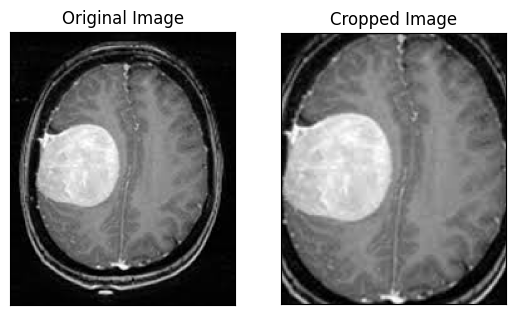

In [3]:
ex_img = cv2.imread('yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

### Load up the data:

In [4]:
def load_data(dir_list, image_size):
    """
    Read images, resize and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [6]:
augmented_path = 'augmented data/'
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'
IMG_WIDTH, IMG_HEIGHT = (240, 240)
X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2065
X shape is: (2065, 240, 240, 3)
y shape is: (2065, 1)


### Plot sample images:

In [7]:
def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

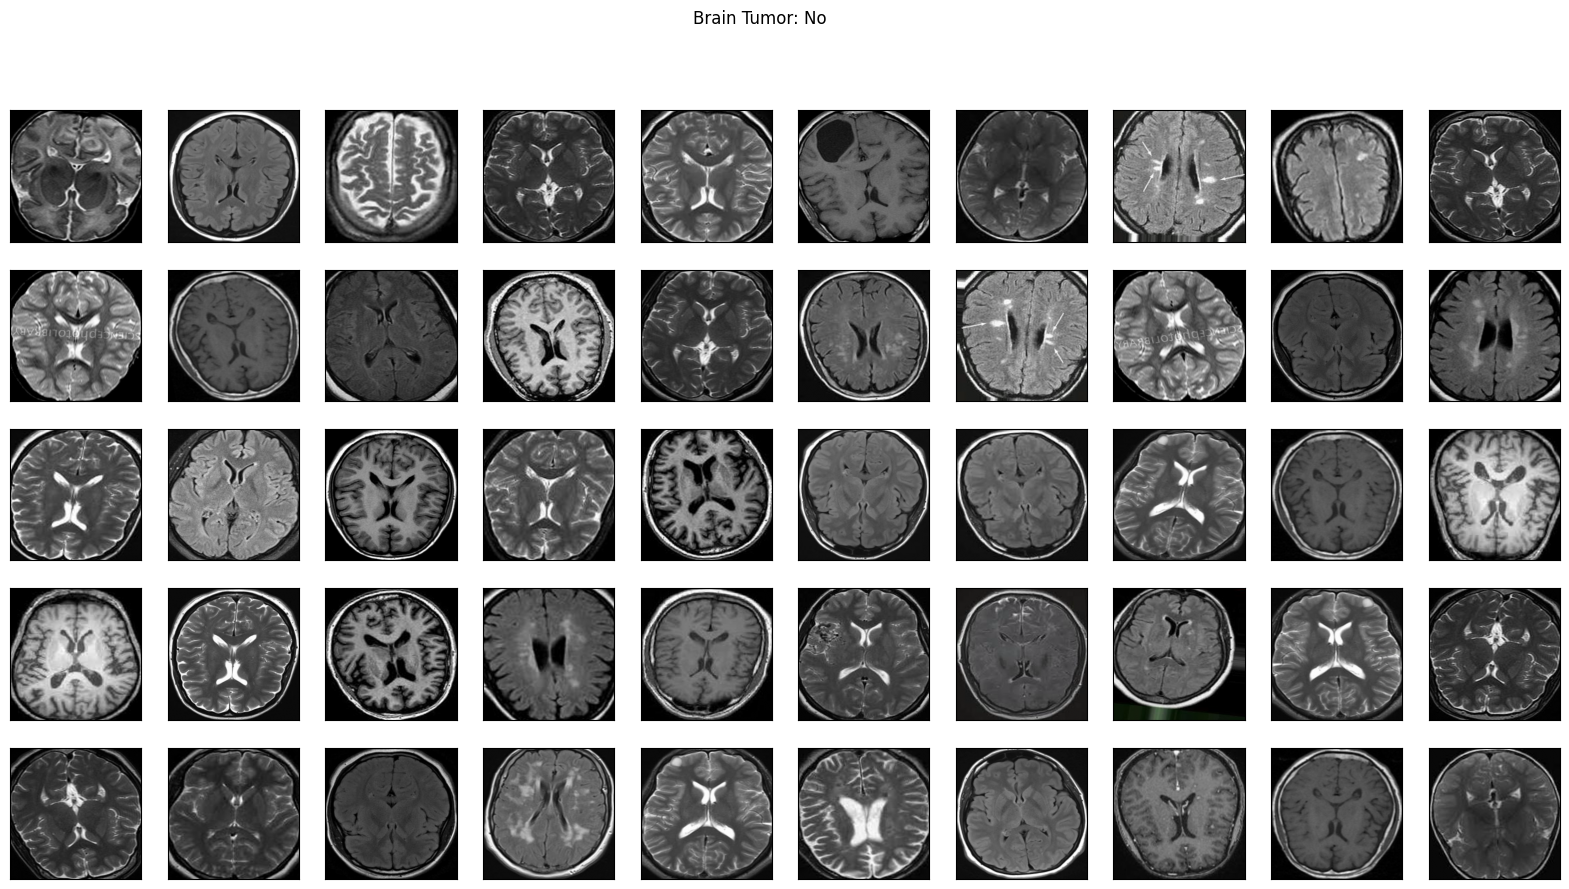

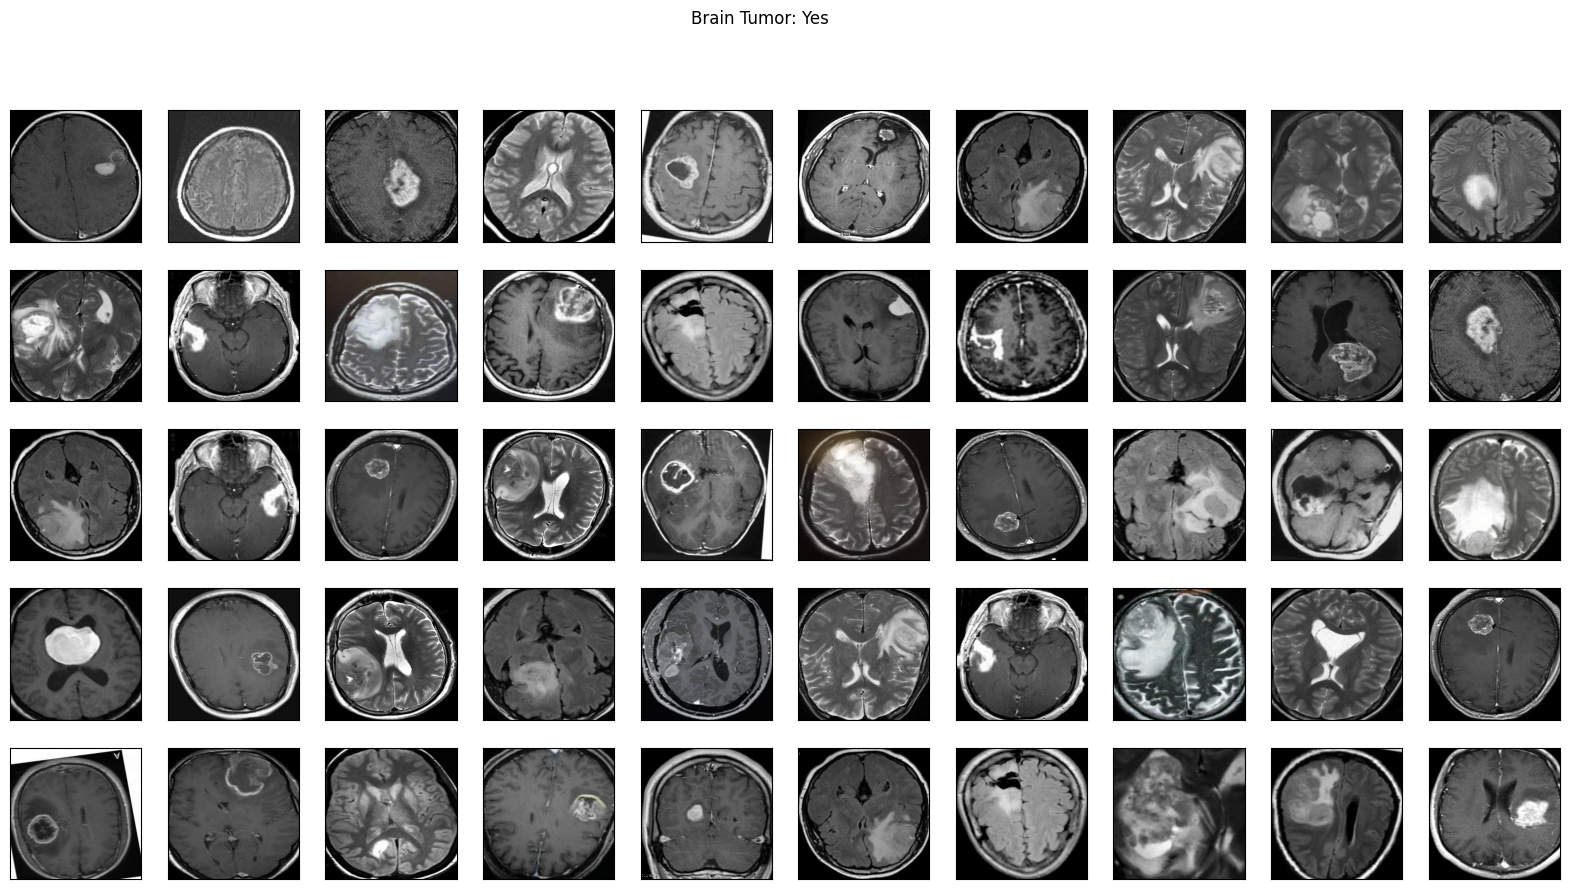

In [8]:
plot_sample_images(X, y)

In [9]:
def split_data(X, y, test_size=0.2):
       
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """
    
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [11]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1445
number of development examples = 310
number of test examples = 310
X_train shape: (1445, 240, 240, 3)
Y_train shape: (1445, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


Some helper functions:

In [12]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [13]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

# Build the model

<img src='convnet_architecture.jpg'>

In [14]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

Define the image shape:

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [16]:
model = build_model(IMG_SHAPE)

In [17]:
model.summary()

Model: "BrainDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 244, 244, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 238, 238, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 238, 238, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 238, 238, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc (Dense)                      │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

Compile the model:

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [20]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"

# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

## Train the model

In [21]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5431 - loss: 1.1871 - val_accuracy: 0.6065 - val_loss: 0.6493
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7180 - loss: 0.5681 - val_accuracy: 0.6935 - val_loss: 0.6051
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7533 - loss: 0.4714 - val_accuracy: 0.7484 - val_loss: 0.5585
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.8117 - loss: 0.4034 - val_accuracy: 0.7839 - val_loss: 0.5208
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8468 - loss: 0.3554 - val_accuracy: 0.6710 - val_loss: 0.5925
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8739 - loss: 0.3160 - val_accuracy: 0.7290 - val_loss: 0.5515
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.8550 - loss: 0.3295 - val_accuracy: 0.8129 - val_loss: 0.4354
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9090 - loss: 0.2397 - val_accuracy: 0.8258 - val_loss:

Let's train for a few more epochs:

In [22]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.9125 - loss: 0.2187 - val_accuracy: 0.6903 - val_loss: 0.7364
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9241 - loss: 0.2131 - val_accuracy: 0.5161 - val_loss: 1.8805
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8921 - loss: 0.2574 - val_accuracy: 0.8226 - val_loss: 0.3935
Elapsed time: 0:4:17.7


In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.9359 - loss: 0.1611 - val_accuracy: 0.8484 - val_loss: 0.3765
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9437 - loss: 0.1571 - val_accuracy: 0.7903 - val_loss: 0.5204
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.9524 - loss: 0.1339 - val_accuracy: 0.7774 - val_loss: 0.5517
Elapsed time: 0:3:54.5


In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9558 - loss: 0.1257 - val_accuracy: 0.8097 - val_loss: 0.3986
Epoch 2/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9369 - loss: 0.1561 - val_accuracy: 0.8129 - val_loss: 0.4047
Epoch 3/3
46/46 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9647 - loss: 0.1166 - val_accuracy: 0.8452 - val_loss: 0.3172
Elapsed time: 0:4:39.2


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9268 - loss: 0.1732 - val_accuracy: 0.8097 - val_loss: 0.4980
Epoch 2/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9561 - loss: 0.1286 - val_accuracy: 0.8484 - val_loss: 0.3653
Epoch 3/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.9594 - loss: 0.1105 - val_accuracy: 0.7194 - val_loss: 0.8741
Epoch 4/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9684 - loss: 0.1102 - val_accuracy: 0.7968 - val_loss: 0.6516
Epoch 5/5
46/46 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9169 - loss: 0.1885 - val_accuracy: 0.7484 - val_loss: 0.7691
Elapsed time: 0:8:1.0


In [26]:
history = model.history.history

In [27]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


## Plot Loss & Accuracy

In [28]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

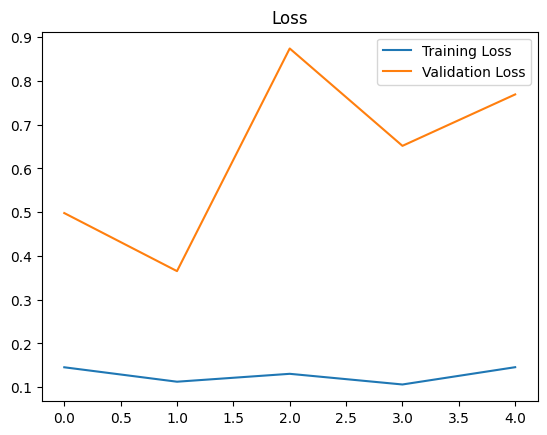

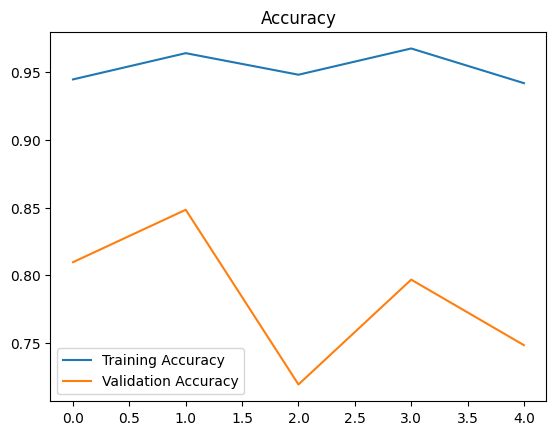

In [29]:
plot_metrics(history) 

### Load the best model

In [35]:
best_model = load_model(filepath='models/models/cnn-parameters-improvement-03-0.85.keras')

In [36]:
best_model.metrics_names

['loss', 'compile_metrics']

Evaluate the best model on the testing data:

In [37]:
loss, compile_metrics = best_model.evaluate(x=X_test, y=y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 224ms/step - accuracy: 0.8637 - loss: 0.3252


### Accuracy of the best model on the testing data:

In [38]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {compile_metrics}")

Test Loss = 0.2859129309654236
Test Accuracy = 0.8806451559066772


### F1 score for the best model on the testing data:

In [39]:
y_test_prob = best_model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 232ms/step


In [40]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8825396825396825


Let's also find the f1 score on the validation data:

In [41]:
y_val_prob = best_model.predict(X_val)

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step


In [42]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.8579881656804734


### Results Interpretation

Let's remember the percentage of positive and negative examples:

In [43]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 



In [44]:
# the whole data
data_percentage(y)

Number of examples: 2065
Percentage of positive examples: 52.54237288135593%, number of pos examples: 1085
Percentage of negative examples: 47.45762711864407%, number of neg examples: 980


In [45]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.94117647058823%, number of pos examples: 765
Percentage of negative examples: 47.05882352941177%, number of neg examples: 680
Validation Data:
Number of examples: 310
Percentage of positive examples: 52.903225806451616%, number of pos examples: 164
Percentage of negative examples: 47.096774193548384%, number of neg examples: 146
Testing Data:
Number of examples: 310
Percentage of positive examples: 50.32258064516129%, number of pos examples: 156
Percentage of negative examples: 49.67741935483871%, number of neg examples: 154


In [48]:
y[0]

array([1])

In [50]:
y_pred = best_model.predict(X)

65/65 ━━━━━━━━━━━━━━━━━━━━ 18s 257ms/step


In [51]:
y_pred[0]

array([0.99988705], dtype=float32)

In [52]:
for i in range(len(y_pred)):
    print(f'y[{i}] = {y[i]} and predicted = {y_pred[i]}')

y[0] = [1] and predicted = [0.99988705]
y[1] = [0] and predicted = [0.00153955]
y[2] = [0] and predicted = [0.02224123]
y[3] = [1] and predicted = [0.99950314]
y[4] = [1] and predicted = [0.9498507]
y[5] = [1] and predicted = [0.99080706]
y[6] = [1] and predicted = [0.99934787]
y[7] = [0] and predicted = [0.00467635]
y[8] = [0] and predicted = [0.03595462]
y[9] = [0] and predicted = [0.01323912]
y[10] = [0] and predicted = [0.6524105]
y[11] = [0] and predicted = [0.4119789]
y[12] = [1] and predicted = [0.9577464]
y[13] = [1] and predicted = [0.8414428]
y[14] = [1] and predicted = [0.8550012]
y[15] = [1] and predicted = [0.54883343]
y[16] = [1] and predicted = [0.8248554]
y[17] = [0] and predicted = [0.12144083]
y[18] = [1] and predicted = [0.9561948]
y[19] = [1] and predicted = [0.99922884]
y[20] = [0] and predicted = [0.09175183]
y[21] = [0] and predicted = [0.00886223]
y[22] = [0] and predicted = [0.00062481]
y[23] = [0] and predicted = [0.24896005]
y[24] = [0] and predicted = [0.633

In [57]:
y_pred_roundoff = []  # Initialize an empty list
for i in range(len(y_pred)):
    if y_pred[i] >= 0.5:
        y_pred_roundoff.append(1)  # Append 1 if prediction >= 0.5
    else:
        y_pred_roundoff.append(0)  # Append 0 if prediction < 0.5

In [58]:
for i in range(len(y_pred)):
    print(f'y[{i}] = {y[i]} and predicted = {y_pred_roundoff[i]}')

y[0] = [1] and predicted = 1
y[1] = [0] and predicted = 0
y[2] = [0] and predicted = 0
y[3] = [1] and predicted = 1
y[4] = [1] and predicted = 1
y[5] = [1] and predicted = 1
y[6] = [1] and predicted = 1
y[7] = [0] and predicted = 0
y[8] = [0] and predicted = 0
y[9] = [0] and predicted = 0
y[10] = [0] and predicted = 1
y[11] = [0] and predicted = 0
y[12] = [1] and predicted = 1
y[13] = [1] and predicted = 1
y[14] = [1] and predicted = 1
y[15] = [1] and predicted = 1
y[16] = [1] and predicted = 1
y[17] = [0] and predicted = 0
y[18] = [1] and predicted = 1
y[19] = [1] and predicted = 1
y[20] = [0] and predicted = 0
y[21] = [0] and predicted = 0
y[22] = [0] and predicted = 0
y[23] = [0] and predicted = 0
y[24] = [0] and predicted = 1
y[25] = [1] and predicted = 1
y[26] = [0] and predicted = 0
y[27] = [0] and predicted = 0
y[28] = [1] and predicted = 1
y[29] = [1] and predicted = 1
y[30] = [0] and predicted = 0
y[31] = [1] and predicted = 1
y[32] = [0] and predicted = 0
y[33] = [0] and pred

In [59]:
correct_predictions = 0
wrong_predictions = 0

for i in range(len(y)):
    if y[i][0] == y_pred_roundoff[i]:  # Compare the actual label with the predicted label
        correct_predictions += 1
    else:
        wrong_predictions += 1

print(f"Number of correct predictions: {correct_predictions}")
print(f"Number of wrong predictions: {wrong_predictions}")

Number of correct predictions: 1941
Number of wrong predictions: 124
